## Group 42 Project - Prize Predictions

### Introduction

The Association of Tennis Professionals (ATP) circuit is for the best male tennis players in the world. The better players perform in each ATP tournament, the more points they accumulate, and the higher the players are ranked. Additionally, for each round that a player wins, they earn prize money. The player who wins the tournament receives the most amount of points and prize money, which can vary based on the tournament level. 

Therefore, based on factors such as current ranking, points accumulated, and best ranking, what would a player's prize money be?  

To do so, we are using the dataset: player_stats, sourced from  https://www.ultimatetennisstatistics.com/ and containing statistical information for the current top 500 tennis players in the ATP. It reports on factors such as handedness and age, although many columns are missing data for a lot of players.


## Method

Given that we are trying to predict a numerical value (prize money), we will be performing a linear regression analysis.

To do so, we will initially load the dataset into R and then clean and tidy it to contain only the relevant columns we need to perform the analysis. We will be using the columns: age, current_rank, points, best_rank, best_rank_date, and prize_money, as we expect them to influence the amount of prize money a player accrues. All other columns will be disregarded when performing regression as they do not aid our predictions, or are missing a significant portion of their values. When creating our prize money column, we decided to mutate it by applying the log() function to all the values. This is because the range is too large within that column, and applying the log function will make the data easier to visualise. 
	
We then create the exploratory datasets by splitting the tidy data into training and testing,  and performing a summary on the training data. Following this, we create a preliminary data visualisation plot, where we create scatter plots of the training data. This allowed us to see a preliminary glance of what variables affected prize money the most. Based on these visualisations, it appeared that ranking seemed to have the strongest correlation to prize money. 

Following this, we performed linear regression on the exploratory dataset. By doing so, we are then able to visualise the linear regression results.  We will be creating multiple scatter plots comparing single factors to prize_money. We will add a second layer to these plots indicating our model's predicted values for the relevant variable. This will allow us to see trends in the predicting variable, as well as the precision of our model in anticipating the effect of that variable on prize money.

We will then create statistics for a hypothetical ATP tennis player and predict how much prize money they will earn based on the predictors.

## Data Analysis 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
install.packages("GGally")
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
#Demonstrate that the dataset can be read from the web into R
tennis_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Clean and wrangle your data into a tidy format
names(tennis_data)[names(tennis_data) == 'Prize Money'] <- 'prize_money'#renames Prize Money column to prize_money
tidy_tennis <- tennis_data |>
    select(Age:Plays,("Current Rank"):prize_money)|> #Removes columns with high proportions of NA 
    separate(col=Age,into=c("age","birth_date"),sep=" ")|> #Separates age and birth date into seperate columns
    separate(col=("Current Rank"),into=c("current_rank","points"),sep=" ")|> 
        #Separates current rank and points into separate columns)
    separate(col=("Best Rank"),into=c("best_rank", "best_rank_date"),sep=" ")|> 
        #Separates best rank and date of best rank into separate columns
    mutate(birth_date= gsub("[()]","",birth_date)) |> #Removes brackets
    mutate(points= gsub("[()]", "", points)) |> #Removes brackets
    mutate(best_rank_date=gsub("[()]","",best_rank_date))|> #Removes brackets
    mutate(birth_date=as_date(birth_date, format='%d-%m-%Y')) |> #Converts birth_date column to date objects
    mutate(best_rank_date=as_date(best_rank_date, format='%d-%m-%Y')) |> #Converts best_rank_date column to date objects
    mutate(age=as.numeric(age)) |> #Converts age column to numberic objects
    mutate(current_rank=as.numeric(current_rank)) |> #Converts current_rank column to numberic objects
    mutate(points=as.numeric(points)) |> #Converts points column to numberic objects
    mutate(best_rank=as.numeric(best_rank))|> #Converts best_rank column to numberic objects
    mutate(prize_money=gsub("[US$,]","",prize_money))|> #Removes some of the non-numeric aspects of prize_money data
    separate(col=prize_money,into=c("prize_money","x"),sep=". ") |> 
        #removes the remaining non-numeric aspects of prize_money data
    select(age:prize_money) |> #removes unnecessary x column, which contained removed non-numeric aspects of prize-money data
    mutate(prize_money=as.numeric(prize_money))|>#converts prize_money column to numeric objects
    mutate(log_prize_money=log(prize_money)) |>#creates log_prize_money column
    drop_na(age)#removes anomalous row in which all values were NA
tidy_tennis<-as.data.frame(tidy_tennis)
tidy_tennis <- tidy_tennis |>
    mutate(best_age=difftime(best_rank_date, birth_date, units="weeks")) |> #determined best age in weeks
    mutate(best_age=best_age/52) |> #determined best age in years
    separate(col=best_age,into=c("best_age","x"),sep="\t") |>#adjusted format to remove "weeks"
    mutate(best_age=as.numeric(best_age))
tidy_tennis <- tidy_tennis %>% mutate(best_age=floor(best_age))
tidy_tennis <- tidy_tennis |>
    select(age, Country, current_rank:best_rank, log_prize_money, best_age) 
slice(tidy_tennis, 1:3)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [16, 96, 128, 142,
208, 212, 267, 274, 337, 363, 364, 381, 394, 414, 423, 435, 436, 461, 468,
497].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 397 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 499 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


age,Country,current_rank,points,best_rank,log_prize_money,best_age
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26,Brazil,378,97,363,NA,26
18,United Kingdom,326,119,316,10.98597,17
32,Slovakia,178,280,44,14.99772,25


In [4]:
#Using only training data, summarize the data in at least one table (this is exploratory data analysis).
set.seed(1111)#allows for reproducible randomness in data
tennis_split <- initial_split(tidy_tennis, prop = 0.75, strata = log_prize_money)#split data into training and testing sets
tennis_training <- training(tennis_split)#pulled training data
tennis_testing <- testing(tennis_split)#pulled testing data
tennis_list <- list(Column=c("age","Country","current_rank",
                             "points","best_rank","prize_money", "log_prize_money", "best_age"),
                    Approximate_Mean=c(26,"NA",247,462,175,2049631, 13, 24),
                    Mode=c(24,"France","NA",69,78,"NA","NA", 26),
                    Rows_with_Missing_Data=c(0,0,3,3,0,58, 58, 0)) 
tennis_summary <- data.frame(tennis_list) 
    #Created summary dataframe using values obtained through analysis steps which have not been included
tennis_summary

Column,Approximate_Mean,Mode,Rows_with_Missing_Data
<chr>,<chr>,<chr>,<dbl>
age,26,24,0
Country,NA,France,0
current_rank,247,NA,3
points,462,69,3
best_rank,175,78,0
prize_money,2049631,NA,58
log_prize_money,13,NA,58
best_age,24,26,0


Warning message:
“Removed 292 rows containing missing values (`geom_point()`).”


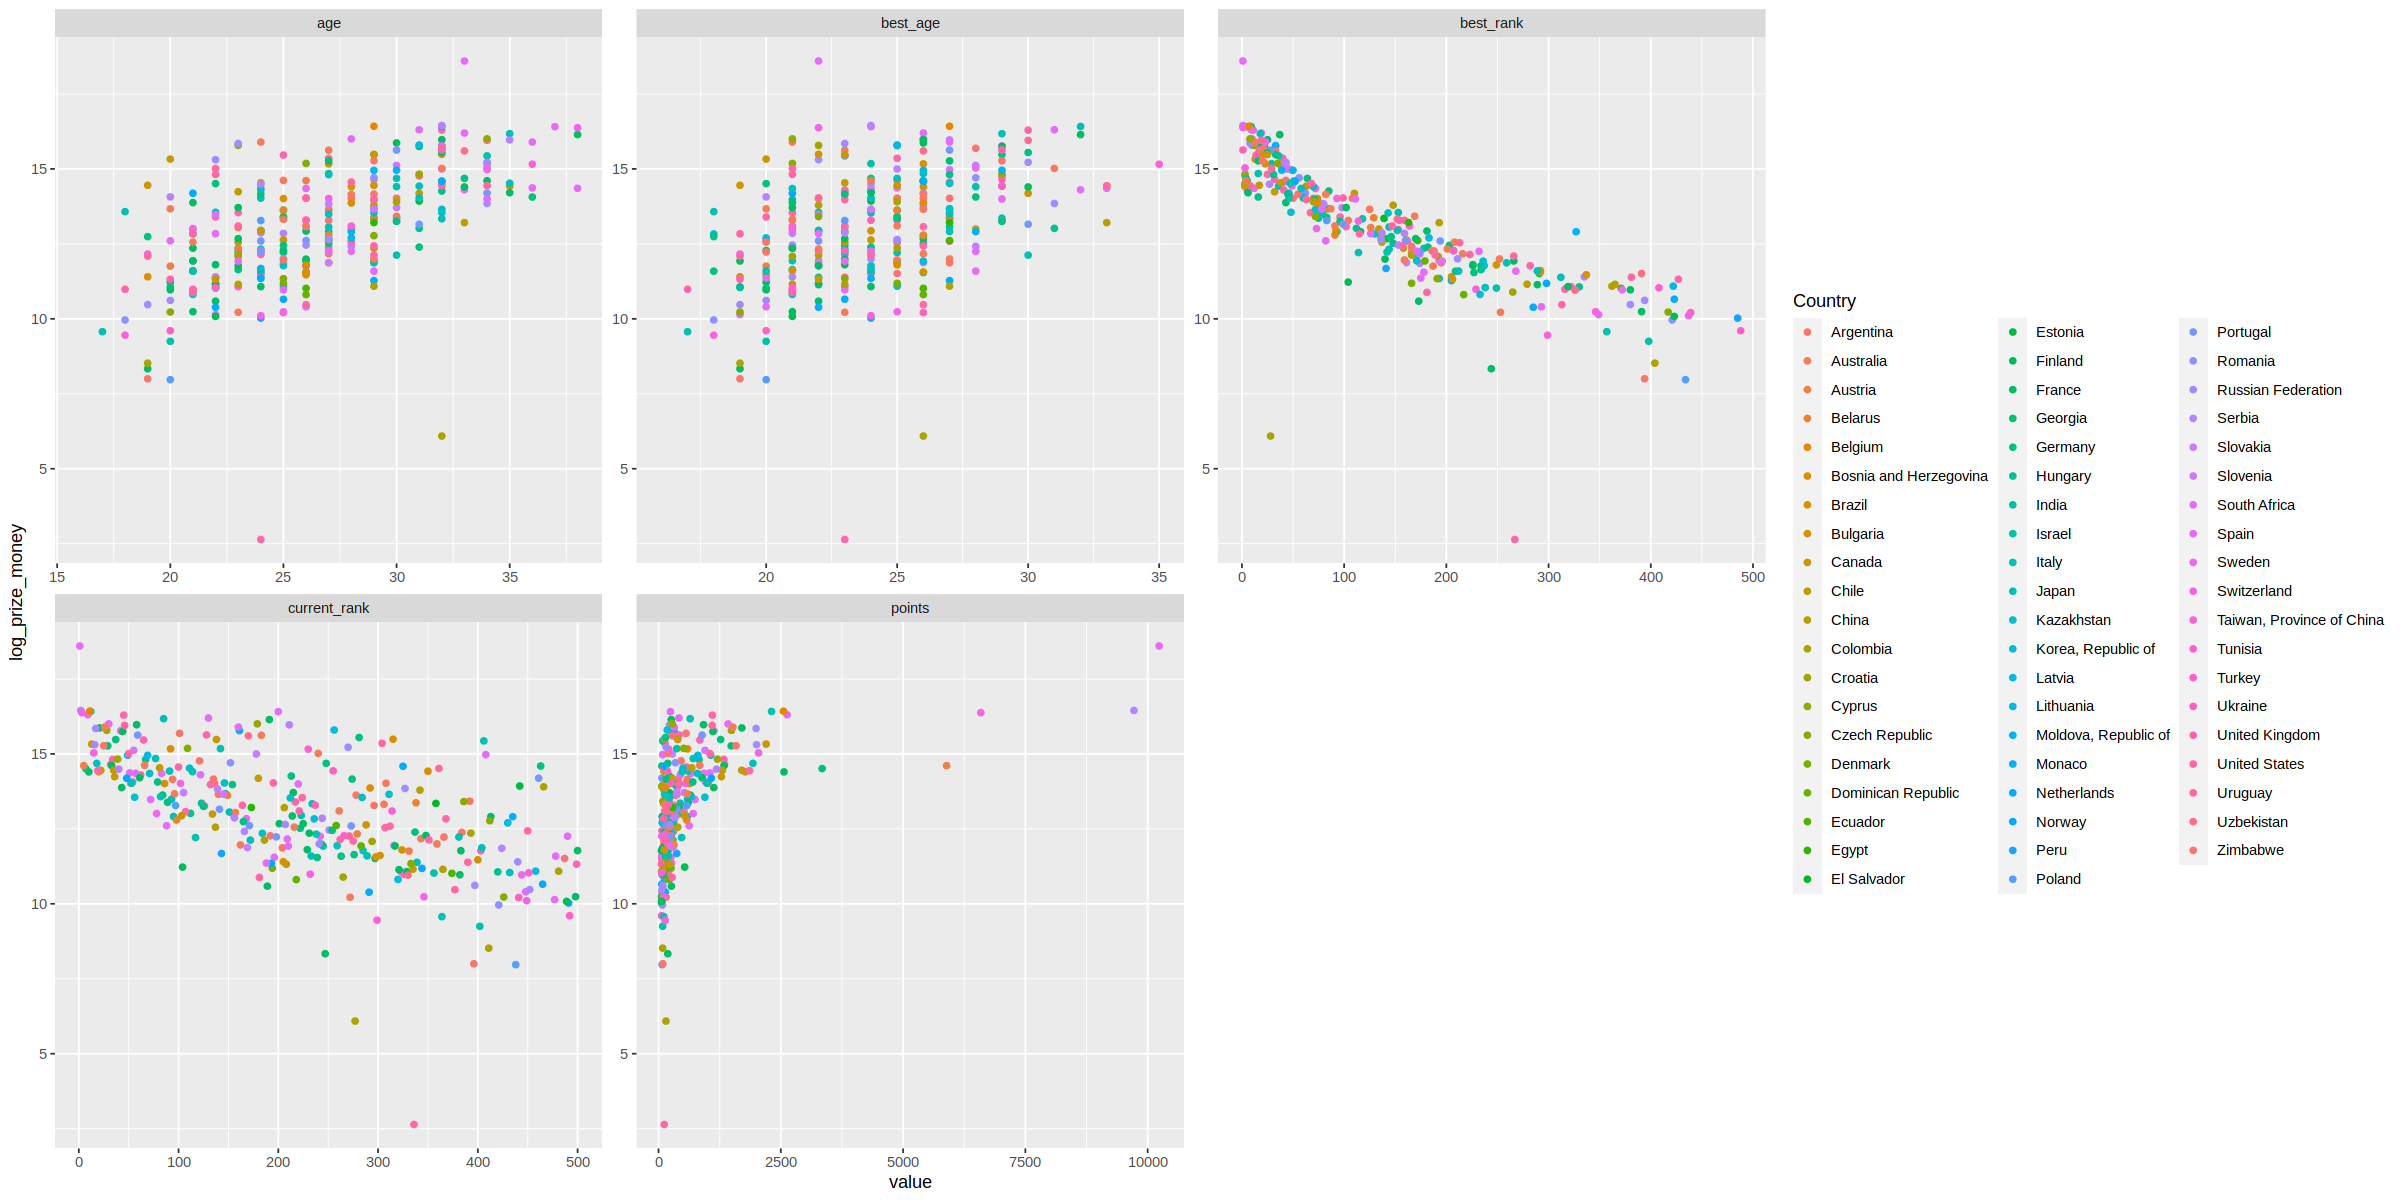

In [6]:
#Preliminary data visualization plot
tennis.gathered <- tennis_training %>%
  as.data.frame() %>%
  gather(key = "variable", value = "value",
         -log_prize_money, -Country)
ggplot(tennis.gathered, aes(x = value, y = log_prize_money)) +
  geom_point(aes(color = Country)) +
  facet_wrap(~variable, scales="free" )
options(repr.plot.height=10, repr.plot.width=100)

In [6]:
# Perform Linear Regression 
set.seed(1111)#allows for reproducible randomness in data
lm_spec <- linear_reg() |>
    set_engine('lm') |>
    set_mode("regression") 

lm_recipe <- recipe(log_prize_money ~. , data = tennis_training)

lm_fit <- workflow () |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec)|>
    fit(tennis_training)

lm_tennis_test_results <- lm_fit |>
    predict(tennis_testing) |>
    bind_cols(tennis_testing) |>
    metrics(truth = log_prize_money, estimate = .pred)

mcoeffs <- lm_fit |>
    extract_fit_parsnip() |>
    tidy()


In [7]:
#Visualise the Linear Regression (superimpose predicted line on original data)
tennis_plot_final <- tennis_training |>
        ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.3)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 20))
tennis_plot_final

#NOTE: NOT FINISHED - Could not figure out how to plot data, ggpairs package not loaded?

ERROR: Error in stop_if_high_cardinality(data, columns, cardinality_threshold): Column 'Country' has more levels (59) than the threshold (15) allowed.
Please remove the column or increase the 'cardinality_threshold' parameter. Increasing the cardinality_threshold may produce long processing times


### Results

In [ ]:
#state results

### Discussion

In [ ]:
#summarize what you found, discuss whether this is what you expected to find?, discuss what impact could such findings have? discuss what future questions could this lead to?

### References

In [ ]:
#At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references)., Make sure to cite the source of your data as well.